# Linear Regression 기반의 검색 빈도수를 이용한 주가예측

# 0. Install packages

In [ ]:
## finance-datereader :: 주가 pip
!pip install finance-datareader
!pip install -U finance-datareader # 업데이트

     |████████████████████████████████| 48 kB 1.2 MB/s 


In [ ]:
import torch
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
import json
import re

# 1. Prepare datasests

## 1-1. 주가 데이터 불러오기

In [ ]:
# Random seed to make results deterministic and reproducible
torch.manual_seed(0)

# 한국거래소에 상장된 모든 종목 리스트 가져오기
import FinanceDataReader as fdr
df_krx = fdr.StockListing('KRX')                ## 'KRX'(한국 종목)만 리스트 가져오기
df_krx.head()

,Symbol,Market,Name,Sector,Industry,ListingDate,SettleMonth,Representative,HomePage,Region
0,060310,KOSDAQ,3S,전자부품 제조업,반도체 웨이퍼 캐리어,2002-04-23,03월,김세완,http://www.3sref.com,서울특별시
1,095570,KOSPI,AJ네트웍스,산업용 기계 및 장비 임대업,"렌탈(파렛트, OA장비, 건설장비)",2015-08-21,12월,"박대현, 손삼달",http://www.ajnet.co.kr,서울특별시
2,006840,KOSPI,AK홀딩스,기타 금융업,지주사업,1999-08-11,12월,"채형석, 이석주(각자 대표이사)",http://www.aekyunggroup.co.kr,서울특별시
3,054620,KOSDAQ,APS홀딩스,기타 금융업,인터넷 트래픽 솔루션,2001-12-04,12월,정기로,http://www.apsholdings.co.kr,경기도
4,265520,KOSDAQ,AP시스템,특수 목적용 기계 제조업,디스플레이 제조 장비,2017-04-07,12월,김영주,http://www.apsystems.co.kr,경기도


In [ ]:
df = fdr.DataReader('036570','2020-01-01', '2022-04-12') # NCsoft 주가를 2020년부터 현시점까지 가져온다

In [ ]:
df

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2020-01-02,542000,545000,539000,541000,40246,0.000000
2020-01-03,547000,568000,542000,565000,112404,0.044362
2020-01-06,562000,587000,562000,579000,107006,0.024779
2020-01-07,583000,596000,574000,594000,84378,0.025907
2020-01-08,587000,604000,584000,604000,109267,0.016835
...,...,...,...,...,...,...
2022-04-06,475000,483500,469000,474000,96750,-0.012500
2022-04-07,469000,471500,462000,462000,103079,-0.025316
2022-04-08,462500,466500,453500,458000,87055,-0.008658


In [ ]:
df = df.fillna(0)

(array([737425., 737516., 737607., 737699., 737791., 737881., 737972.,
        738064., 738156., 738246.]),
 <a list of 10 Text major ticklabel objects>)

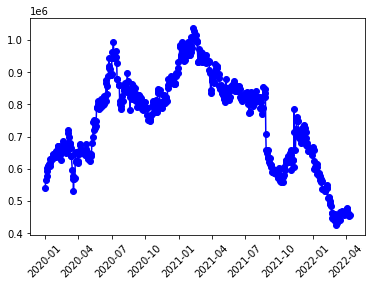

In [ ]:
plt.plot(df['Close'], 'bo-')
plt.xticks(rotation=45)

## 1-2. Naver API 키워드 검색 데이터 불러오기

In [ ]:
import os
import sys
import urllib.request
client_id = "8sAydq_QSOxKcICuD2Og"
client_secret = "OruQjbmaXF"
url = "https://openapi.naver.com/v1/datalab/search";
body = "{\"startDate\":\"2020-01-01\",\"endDate\":\"2022-04-12\",\"timeUnit\":\"date\",\"keywordGroups\":[{\"groupName\":\"리니지\",\"keywords\":[\"리니지\",\"Lineage\"]}],\"device\":\"pc\",\"ages\":[\"1\",\"2\"],\"gender\":\"m\"}";

request = urllib.request.Request(url)
request.add_header("X-Naver-Client-Id",client_id)
request.add_header("X-Naver-Client-Secret",client_secret)
request.add_header("Content-Type","application/json")
response = urllib.request.urlopen(request, data=body.encode("utf-8"))
rescode = response.getcode()
if(rescode==200):
    response_body = response.read()
    #print(response_body.decode('utf-8'))
    search_count = response_body.decode('utf-8')
else:
    print("Error Code:" + rescode)

In [ ]:
search_count_json = json.loads(search_count)            ## '리니지'에 관련된 키워드의 비율

In [ ]:
search_count_json       

In [ ]:
df_json = pd.DataFrame(search_count_json["results"][0]["data"])

In [ ]:
df_json

,period,ratio
0,2020-01-01,35.08771
1,2020-01-02,35.08771
2,2020-01-03,17.54385
3,2020-01-04,26.31578
4,2020-01-05,14.03508
...,...,...
826,2022-04-08,7.01754
827,2022-04-09,14.03508
828,2022-04-10,10.52631
829,2022-04-11,8.77192


## 1-3. 데이터 전처리 및 Merge하기

In [ ]:
df_json.columns = ['Date', 'Count']

In [ ]:
df_json['Date'] = pd.to_datetime(df_json['Date'])

In [ ]:
df_json

,Date,Count
0,2020-01-01,35.08771
1,2020-01-02,35.08771
2,2020-01-03,17.54385
3,2020-01-04,26.31578
4,2020-01-05,14.03508
...,...,...
826,2022-04-08,7.01754
827,2022-04-09,14.03508
828,2022-04-10,10.52631
829,2022-04-11,8.77192


In [ ]:
df_json.reset_index(drop=True)
df_json.set_index("Date")

,Count
Date,
2020-01-01,35.08771
2020-01-02,35.08771
2020-01-03,17.54385
2020-01-04,26.31578
2020-01-05,14.03508
...,...
2022-04-08,7.01754
2022-04-09,14.03508
2022-04-10,10.52631


In [ ]:
#Please refer to the section of "Merging asof" in https://pandas.pydata.org/docs/user_guide/merging.html
df_all = pd.merge_asof(df, df_json, on="Date", by="Date")

In [ ]:
df_all

,Date,Open,High,Low,Close,Volume,Change,Count
0,2020-01-02,542000,545000,539000,541000,40246,0.000000,35.08771
1,2020-01-03,547000,568000,542000,565000,112404,0.044362,17.54385
2,2020-01-06,562000,587000,562000,579000,107006,0.024779,21.05263
3,2020-01-07,583000,596000,574000,594000,84378,0.025907,7.01754
4,2020-01-08,587000,604000,584000,604000,109267,0.016835,36.84210
...,...,...,...,...,...,...,...,...
558,2022-04-06,475000,483500,469000,474000,96750,-0.012500,3.50877
559,2022-04-07,469000,471500,462000,462000,103079,-0.025316,5.26315
560,2022-04-08,462500,466500,453500,458000,87055,-0.008658,7.01754
561,2022-04-11,450500,459000,449000,453500,59322,-0.009825,8.77192


In [ ]:
pd.set_option('display.max_row', 600)

In [ ]:
df_all["Count"]

In [ ]:
## nan 찾기 - count 값 중 nan이 있다..!!
df_all["Count"].fillna(0)

0       35.08771
1       17.54385
2       21.05263
3        7.01754
4       36.84210
5       17.54385
6       21.05263
7       14.03508
8       15.78947
9       15.78947
10      10.52631
11      19.29824
12       7.01754
13      14.03508
14      31.57894
15      24.56140
16      19.29824
17      33.33333
18      36.84210
19      35.08771
20      22.80701
21      19.29824
22      15.78947
23      31.57894
24      14.03508
25      29.82456
26      26.31578
27      49.12280
28      17.54385
29      22.80701
30      24.56140
31      26.31578
32      22.80701
33      28.07017
34      28.07017
35      22.80701
36      43.85964
37      29.82456
38      19.29824
39      26.31578
40      33.33333
41      29.82456
42      19.29824
43      42.10526
44      24.56140
45      15.78947
46      31.57894
47      33.33333
48      35.08771
49      17.54385
50      29.82456
51      29.82456
52      31.57894
53      52.63157
54      17.54385
55      19.29824
56      26.31578
57      15.78947
58      36.842

In [ ]:
## nan 찾기 - count 값 중 nan이 있다..!!
df_all["Change"].fillna(0)

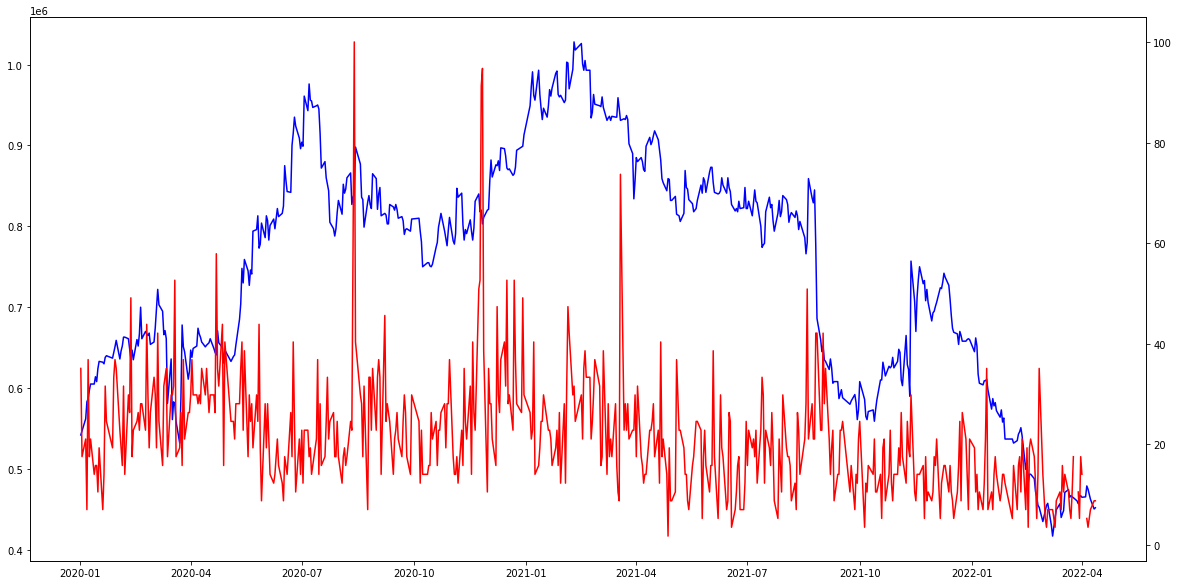

In [ ]:
## You need to visualized a relational graph                                ## 직접 그려보기

# plt.figure(figsize=(40,20))
fig, ax1 = plt.subplots()
ax1.plot(df_all['Date'], df_all['Open'], color='blue')

ax2 = ax1.twinx()
ax2.plot(df_all['Date'], df_all['Count'], color='red')

fig.set_size_inches(20, 10)

plt.show()

In [ ]:
df_all.any().isnull()

Date      False
Open      False
High      False
Low       False
Close     False
Volume    False
Change    False
Count     False
dtype: bool

In [ ]:
# scaling function for input data
def minmax_scaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)

# scaling function for input data
def minmax_scaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)


# make dataset to train

# 2. Define Model

In [ ]:
class LinearModel(torch.nn.Module):                                                     ## 확장하고 싶을 때 torch.nn.Module을 상속 받아서 LinearModel을 정의함
    def __init__(self, input_dim, output_dim):                                          ## init 함수 : 인스턴스를 생성할 때
        super(LinearModel, self).__init__()
        self.linear_classifier = torch.nn.Linear(input_dim, output_dim, bias=True)

    def forward(self, x):                                                               ## forward 함수 : 실제로 실행할 때
        print("inX:" ,x)
        print("inSquee",x.unsqueeze(0))
        x = self.linear_classifier(x.unsqueeze(0))
        print("outX:" ,x)
        return x

# 3. Define the loss function and the optimizer

In [ ]:
input_dim = 1
output_dim = 1
learning_rate = 0.01
model = LinearModel(input_dim, output_dim)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_function = torch.nn.MSELoss()

# 4. Define train function

In [ ]:
def train(train_x, train_y, loss_function, optimizer, model):

  for idx in range(len(train_x)):
    model.train()
    optimizer.zero_grad()
    print('##### ' + str(idx) + '번째 train 수행중 #####')
    print('train_x: ' + str(train_x[idx]))
    train_x_tensor = torch.tensor(train_x[idx]).float() #convert numpy to torch tensor
    train_y_tensor = torch.tensor(train_y[idx]).float()
    logit = model(train_x_tensor)
    print("the value of logit", logit)
    loss = loss_function(logit, train_y_tensor)
    print("the value of loss", loss)

    loss.backward()
    optimizer.step()

  return ""

# 5. Training 

In [ ]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(df_all["Count"].to_numpy(),df_all["Change"].to_numpy(), test_size=0.2)

In [ ]:
## nan 제거
from sklearn.model_selection import train_test_split
df_count = df_all["Count"].fillna(0)
df_change = df_all["Change"].fillna(0)

In [ ]:
def mean_norm(df):
    return df.apply(lambda x: (x - np.mean(df)) / np.std(df))

In [ ]:
pd.set_option('display.max_row', 10)

In [ ]:
df_count_norm = mean_norm(df_count)
df_change_norm = mean_norm(df_change)

In [ ]:
df_count_norm = (df_count - np.mean(df_count)) / np.std(df_count)

In [ ]:
df_change_norm = (df_change - np.mean(df_change)) / np.std(df_change)

In [ ]:
# normalize . numpy
train_x, test_x, train_y, test_y = train_test_split(df_count_norm.to_numpy(),df_change_norm.to_numpy(), test_size=0.2)

In [ ]:
# normalize . numpy
train_x, test_x, train_y, test_y = train_test_split(df_count_norm.to_numpy(),df_change_norm.to_numpy(), test_size=0.2)

In [ ]:
best_model = None
best_model = train(train_x, train_y, loss_function, optimizer, model)

##### 306번째 train 수행중 #####
train_x: 1.1659151895895519
inX: tensor(1.1659)
inSquee tensor([1.1659])
outX: tensor([nan], grad_fn=<AddBackward0>)
the value of logit tensor([nan], grad_fn=<AddBackward0>)
the value of loss tensor(nan, grad_fn=<MseLossBackward0>)
##### 307번째 train 수행중 #####
train_x: -1.244588556602585
inX: tensor(-1.2446)
inSquee tensor([-1.2446])
outX: tensor([nan], grad_fn=<AddBackward0>)
the value of logit tensor([nan], grad_fn=<AddBackward0>)
the value of loss tensor(nan, grad_fn=<MseLossBackward0>)
##### 308번째 train 수행중 #####
train_x: -0.039336254135453504
inX: tensor(-0.0393)
inSquee tensor([-0.0393])
outX: tensor([nan], grad_fn=<AddBackward0>)
the value of logit tensor([nan], grad_fn=<AddBackward0>)
the value of loss tensor(nan, grad_fn=<MseLossBackward0>)
##### 309번째 train 수행중 #####
train_x: 1.1659151895895519
inX: tensor(1.1659)
inSquee tensor([1.1659])
outX: tensor([nan], grad_fn=<AddBackward0>)
the value of logit tensor([nan], grad_fn=<AddBackward0>)
the value o

In [ ]:
#len(train_y)
len(train_x)

450

# 6. Prediction

In [ ]:
def predict():
  return ""